# SEISMIC INVERSION USING MACHINE LEARNING

This notebook builds an end-to-end Long Short Term Memory Model using XGBoost

## Problem
Geophysics in the Cloud was a competition with the goal to perform seismic inversion of rock attributes from seismic data with the use of well logs. 

## Data
Data used in this project came from open data (3D Poseidon from Australia). Seismic acquisition in 2009 by ConoPhilips
Data given:
- Near, Mid, Far offset seismic
- Migration Velocity
- Sonic Logs
- Gamma
- Porosity
- Resistivity Logs

## Goal
Performing inversions for P-Impedance, S-Impedance, and Density.

## Evaluation

* MAE = (1/n) * Σ|yi – xi|
* R2 = 1 - ${\frac{RSS}{TSS}}$ \\
R^2	=	coefficient of determination \\
RSS	=	sum of squares of residuals \\
TSS	=	total sum of squares \\
* ME: maximum residual error

## Features

1. Well logs with DTC (transit-time of compressional wave), DTS (transit-time of shear wave) and RHOB (bulk density) are used for training and evaluation. 
2. Data is from Two blind wells. 
3. The provided logs contain a large amount of missing data.

#### Inversion Info
Equations: 
- Zp = Vp * Rhob
- Zs = Vs * Rhob

### 1. Get workspace ready

In [335]:
from time import time
import pandas as pd
import numpy as np
from numpy import reshape
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.misc import derivative
from scipy.interpolate import interp1d
from scipy.signal import hilbert,chirp 

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, r2_score, max_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from xgboost import XGBRegressor, plot_importance

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, LSTM
from keras.layers.convolutional import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow.keras as k

### 2. Cleaning and imputing data
Given the size of SEGY files and the lack of computer power I decided to skip the data cleaning and imputation part. 

### 3. Data Engineering and augmentation
- Creating new features from provided data.
- Generate standard AVO attributes.
    * Stack(sum of Near, Mid and Far)
    * Intercept and gradient
    * Rp = Intercept and Rs (Intercept - Gradient)
    * Pseudo_Curvature = Gradient(Far-Mid) - Gradient(Far-Near)
    * Integration of Rp/Intercept(RAIp)
    * Integration of the Rs (RAIs)
    * Integration of the ABS of the Rp and Rs

In [250]:
cleaned_data = pd.read_csv('../Datasets/Seismic Inversion/input_label_04-22_3.csv')
cleaned_data

,well_id,well_enc,twt,rhob,vp,vs,formation,seis_near,seis_mid,seis_far,bg_vel
0,well_01,0,2180.5,2.583062,4535.708695,2274.160045,2,-6749.200079,-4651.793791,-6010.635571,4819.458925
1,well_01,0,2181.0,2.590539,4677.809167,2297.976146,2,-4500.335374,-4519.011920,-6720.620094,4824.308579
2,well_01,0,2181.5,2.576754,4603.527613,2344.096821,2,-2231.685365,-4388.921156,-7496.044290,4829.038659
3,well_01,0,2182.0,2.575342,4599.998286,2301.914494,2,-30.777578,-4282.545106,-8325.698097,4833.651971
4,well_01,0,2182.5,2.569139,4419.725343,2204.455407,2,2014.860464,-4220.907376,-9198.371453,4838.151318
...,...,...,...,...,...,...,...,...,...,...,...
12014,well_33,5,3275.5,2.569400,4519.815568,2929.818873,5,-803.581876,-4711.583241,-1125.603100,4327.822576
12015,well_33,5,3276.0,2.582800,4216.256270,2787.222700,5,-1391.222656,-3826.451172,-147.460938,4328.605353
12016,well_33,5,3276.5,2.434100,4429.262807,2915.983821,5,-1925.526963,-2953.606704,878.858622,4329.388793
12017,well_33,5,3277.0,2.399700,4268.654570,2889.920826,5,-2392.757260,-2097.157356,1939.549811,4330.172862


In [251]:
# Set 'well_id' as the index
cleaned_data.set_index(['well_id'], inplace=True)
cleaned_data

,well_enc,twt,rhob,vp,vs,formation,seis_near,seis_mid,seis_far,bg_vel
well_id,,,,,,,,,,
well_01,0,2180.5,2.583062,4535.708695,2274.160045,2,-6749.200079,-4651.793791,-6010.635571,4819.458925
well_01,0,2181.0,2.590539,4677.809167,2297.976146,2,-4500.335374,-4519.011920,-6720.620094,4824.308579
well_01,0,2181.5,2.576754,4603.527613,2344.096821,2,-2231.685365,-4388.921156,-7496.044290,4829.038659
well_01,0,2182.0,2.575342,4599.998286,2301.914494,2,-30.777578,-4282.545106,-8325.698097,4833.651971
well_01,0,2182.5,2.569139,4419.725343,2204.455407,2,2014.860464,-4220.907376,-9198.371453,4838.151318
...,...,...,...,...,...,...,...,...,...,...
well_33,5,3275.5,2.569400,4519.815568,2929.818873,5,-803.581876,-4711.583241,-1125.603100,4327.822576
well_33,5,3276.0,2.582800,4216.256270,2787.222700,5,-1391.222656,-3826.451172,-147.460938,4328.605353
well_33,5,3276.5,2.434100,4429.262807,2915.983821,5,-1925.526963,-2953.606704,878.858622,4329.388793


In [252]:
wells = list(cleaned_data.index.unique())
wells

['well_01', 'well_11', 'well_21', 'well_25', 'well_27', 'well_33']

In [253]:
# Get the columns we are going to use 
columns = ['seis_near', 'seis_mid', 'seis_far', 'bg_vel']

In [254]:
cleaned_data.groupby('well_id').count()

,well_enc,twt,rhob,vp,vs,formation,seis_near,seis_mid,seis_far,bg_vel
well_id,,,,,,,,,,
well_01,2311,2311,2311,2311,2311,2311,2311,2311,2311,2311
well_11,1688,1688,1688,1688,1688,1688,1688,1688,1688,1688
well_21,2549,2549,2549,2549,2549,2549,2549,2549,2549,2549
well_25,2031,2031,2031,2031,2031,2031,2031,2031,2031,2031
well_27,2776,2776,2776,2776,2776,2776,2776,2776,2776,2776
well_33,664,664,664,664,664,664,664,664,664,664


In [255]:
# Sample rate for integral on derivates
sample_rate = 0.0005

# Angle dependent amplitude values from sin2 (calculated from equations based on angle difference between the near, mid and far offsets)
near_angle = 0.043
mid_angle = 0.165
far_angle = 0.349
max_angle = 0.448

#### AVO Attributes


1. Integrated Amplitude.- sum of all previous trace values
2. Integrated Absolute Amplitude.- sum of all previous trace amplitudes 
3. Derivative Amplitude.- local derivative of trace

In [256]:
# Generating these new attributes by well
for well in wells:
    for column in columns:
        data_array = cleaned_data.loc[well][column].to_numpy(copy=True)
        cleaned_data.loc[well,column+'_integral'] = np.append(data_array[0]*sample_rate,integrate.cumtrapz(data_array,dx=sample_rate))
        cleaned_data.loc[well,column+'_integral_abs'] = np.append(abs(data_array[0])*sample_rate,integrate.cumtrapz(abs(data_array),dx=sample_rate))
        cleaned_data.loc[well,column+'_derivative'] = np.gradient(data_array,sample_rate)

cleaned_data.shape

(12019, 22)

4. Instantaneous Amplitude.- used to isolate high or low amplitude areas such as bright and dim spots.
5. Instantaneous Phase.- the tangencial angle of the phase of traces.
6. Cosine Instantaneous Phase .- derived from instantaneous phase.
7. Instantaneous frequency.- derive from instantaneous pahse with respect of time.
8. Amplitud weighted instantaneous frequency .- instantaneous frequency qith amplitude. Smooth method to estimate Inst-Freq.

In [257]:
# Generating the attributes by well

for well in wells:
    for column in columns[:-1]:
        data_array = cleaned_data.loc[well][column].to_numpy(copy=True)
        analytic_signal = hilbert(data_array)
        cleaned_data.loc[well,column+'_inst_Amp'] = np.abs(analytic_signal)
        cleaned_data.loc[well,column+'_inst_cosPhs'] = np.cos(np.angle(analytic_signal)) * cleaned_data.loc[well,column+'_inst_Amp']
            
        instantaneous_phase = np.unwrap(np.angle(analytic_signal))
        cleaned_data.loc[well,column+'_inst_Phs'] = instantaneous_phase
            
        instantaneous_frequency = (np.diff(instantaneous_phase)/(2.0*np.pi) * (1/sample_rate))
        cleaned_data.loc[well,column+'_inst_Freq'] = np.append(instantaneous_frequency[0],instantaneous_frequency)
        cleaned_data.loc[well,column+'_ampW_inst_Freq'] = cleaned_data.loc[well,column+'_inst_Freq']/np.abs(analytic_signal)
        cleaned_data.loc[well,column+'_ampW_inst_Phs'] = instantaneous_phase/np.abs(analytic_signal)

cleaned_data.shape

(12019, 40)

In [258]:
# Get gradient and intercept
for well in wells:
    for column in columns:
      near  = cleaned_data.loc[well]['seis_near'].to_numpy(copy=True)
      mid   = cleaned_data.loc[well]['seis_mid'].to_numpy(copy=True)
      far   = cleaned_data.loc[well]['seis_far'].to_numpy(copy=True)
      rhob  = cleaned_data.loc[well]['rhob'].to_numpy(copy=True)
      
      stack = (near+mid+far)/3
      cleaned_data.loc[well,'gradient'] = ((mid-near)/(mid_angle-near_angle)+(far-mid)/(far_angle-mid_angle))/2*max_angle
      cleaned_data.loc[well,'intercept'] = stack-cleaned_data.loc[well,'gradient']/2
      
cleaned_data.head()

,well_enc,twt,rhob,vp,vs,formation,seis_near,seis_mid,seis_far,bg_vel,...,seis_mid_ampW_inst_Freq,seis_mid_ampW_inst_Phs,seis_far_inst_Amp,seis_far_inst_cosPhs,seis_far_inst_Phs,seis_far_inst_Freq,seis_far_ampW_inst_Freq,seis_far_ampW_inst_Phs,gradient,intercept
well_id,,,,,,,,,,,,,,,,,,,,,
well_01,0,2180.5,2.583062,4535.708695,2274.160045,2,-6749.200079,-4651.793791,-6010.635571,4819.458925,...,0.020504,0.000591,7761.393934,-6010.635571,-2.456606,-281.729554,-0.036299,-0.000317,2196.733312,-6902.243136
well_01,0,2181.0,2.590539,4677.809167,2297.976146,2,-4500.335374,-4519.011920,-6720.620094,4824.308579,...,0.021961,0.000702,6857.438474,-6720.620094,-3.341685,-281.729554,-0.041084,-0.000487,-2714.510009,-3889.400791
well_01,0,2181.5,2.576754,4603.527613,2344.096821,2,-2231.685365,-4388.921156,-7496.044290,4829.038659,...,-0.001454,0.000718,7587.242993,-7496.044290,-3.296797,14.288435,0.001883,-0.000435,-7743.411054,-833.844743
well_01,0,2182.0,2.575342,4599.998286,2301.914494,2,-30.777578,-4282.545106,-8325.698097,4833.651971,...,0.005874,0.000751,8862.296165,-8325.698097,-3.491363,-61.932216,-0.006988,-0.000394,-12728.623280,2151.304713
well_01,0,2182.5,2.569139,4419.725343,2204.455407,2,2014.860464,-4220.907376,-9198.371453,4838.151318,...,-0.003766,0.000753,9583.535752,-9198.371453,-3.426065,20.784777,0.002169,-0.000357,-17508.800142,4952.927283


#### Plotting data by well

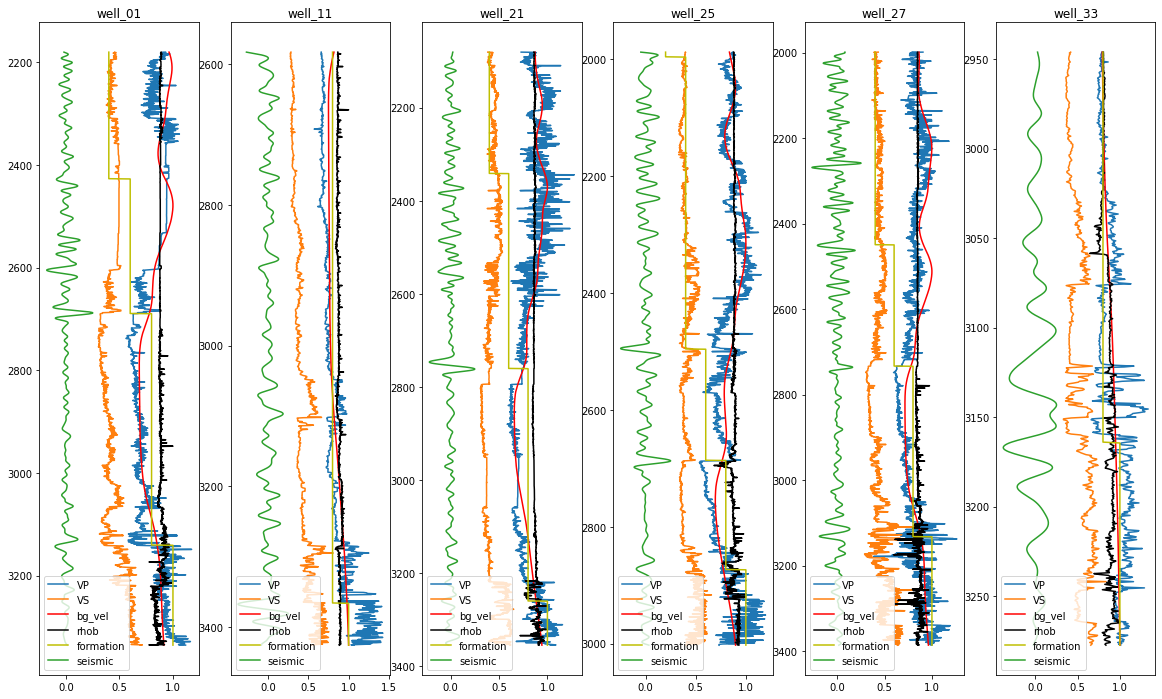

In [259]:
fig, axs = plt.subplots(1,6, figsize=(20,12))
i=0
new_attributes = False
for well in wells:
    if new_attributes == False:
        axs[i].plot(cleaned_data.loc[well]['vp']/max(cleaned_data.loc[well]['bg_vel']),cleaned_data.loc[well]['twt'],label='VP')
        axs[i].plot(cleaned_data.loc[well]['vs']/max(cleaned_data.loc[well]['bg_vel']),cleaned_data.loc[well]['twt'],label='VS')
        axs[i].plot(cleaned_data.loc[well]['bg_vel']/max(cleaned_data.loc[well]['bg_vel']),cleaned_data.loc[well]['twt'],label='bg_vel',color='r')
        axs[i].plot(cleaned_data.loc[well]['rhob']/max(cleaned_data.loc[well]['rhob']),cleaned_data.loc[well]['twt'],label='rhob',color='k')
        axs[i].plot(cleaned_data.loc[well]['formation']/max(cleaned_data.loc[well]['formation']),cleaned_data.loc[well]['twt'],label='formation',color='y')
        axs[i].plot(cleaned_data.loc[well]['seis_near']/(4*max(cleaned_data.loc[well]['seis_near'])),cleaned_data.loc[well]['twt'],label='seismic')

    if new_attributes == True:    
        axs[i].plot(cleaned_data.loc[well]['seis_near_inst_Freq']/max(cleaned_data.loc[well]['seis_near_inst_Freq']),cleaned_data.loc[well]['twt'],label='seis_near_inst_Freq',color='y')
        axs[i].plot(cleaned_data.loc[well]['seis_near_inst_Phs']/max(cleaned_data.loc[well]['seis_near_inst_Phs']),cleaned_data.loc[well]['twt'],label='seis_near_inst_Phs',color='k')
        axs[i].plot(cleaned_data.loc[well]['seis_near_ampW_inst_Freq']/max(cleaned_data.loc[well]['seis_near_ampW_inst_Freq']),cleaned_data.loc[well]['twt'],label='seis_near_ampW_inst_Freq',color='b')

    axs[i].invert_yaxis()
    axs[i].title.set_text(well)
    axs[i].legend();
    i += 1

#### Saving dataset with the new features

In [260]:
cleaned_data.to_csv('..\Datasets\Seismic Inversion\data_eng.csv')

### 4. Building a model

In [261]:
data = pd.read_csv('..\Datasets\Seismic Inversion\data_eng.csv', index_col=[0,2])
data.head()

well_enc      rhob           vp           vs  formation  \
well_id twt                                                               
well_01 2180.5         0  2.583062  4535.708695  2274.160045          2   
        2181.0         0  2.590539  4677.809167  2297.976146          2   
        2181.5         0  2.576754  4603.527613  2344.096821          2   
        2182.0         0  2.575342  4599.998286  2301.914494          2   
        2182.5         0  2.569139  4419.725343  2204.455407          2   

                  seis_near     seis_mid     seis_far       bg_vel  \
well_id twt                                                          
well_01 2180.5 -6749.200079 -4651.793791 -6010.635571  4819.458925   
        2181.0 -4500.335374 -4519.011920 -6720.620094  4824.308579   
        2181.5 -2231.685365 -4388.921156 -7496.044290  4829.038659   
        2182.0   -30.777578 -4282.545106 -8325.698097  4833.651971   
        2182.5  2014.860464 -4220.907376 -9198.371453  4838.151318   

                seis_near_integral  ...  seis_mid_ampW_inst_Freq  \
well_id twt                         ...                            
well_01 2180.5           -3.374600  ...                 0.020504   
        2181.0           -2.812384  ...                 0.021961   
        2181.5           -4.495389  ...                -0.001454   
        2182.0           -5.061005  ...                 0.005874   
        2182.5           -4.564984  ...                -0.003766   

                seis_mid_ampW_inst_Phs  seis_far_inst_Amp  \
well_id twt                                                 
well_01 2180.5                0.000591        7761.393934   
        2181.0                0.000702        6857.438474   
        2181.5                0.000718        7587.242993   
        2182.0                0.000751        8862.296165   
        2182.5                0.000753        9583.535752   

                seis_far_inst_cosPhs  seis_far_inst_Phs  seis_far_inst_Freq  \
well_id twt                                                                   
well_01 2180.5          -6010.635571          -2.456606         -281.729554   
        2181.0          -6720.620094          -3.341685         -281.729554   
        2181.5          -7496.044290          -3.296797           14.288435   
        2182.0          -8325.698097          -3.491363          -61.932216   
        2182.5          -9198.371453          -3.426065           20.784777   

                seis_far_ampW_inst_Freq  seis_far_ampW_inst_Phs      gradient  \
well_id twt                                                                     
well_01 2180.5                -0.036299               -0.000317   2196.733312   
        2181.0                -0.041084               -0.000487  -2714.510009   
        2181.5                 0.001883               -0.000435  -7743.411054   
        2182.0                -0.006988               -0.000394 -12728.623280   
        2182.5                 0.002169               -0.000357 -17508.800142   

                  intercept  
well_id twt                  
well_01 2180.5 -6902.243136  
        2181.0 -3889.400791  
        2181.5  -833.844743  
        2182.0  2151.304713  
        2182.5  4952.927283  

[5 rows x 41 columns]

In [262]:
# Check if data has no missing values
data.isnull().sum()

well_enc                    0
rhob                        0
vp                          0
vs                          0
formation                   0
seis_near                   0
seis_mid                    0
seis_far                    0
bg_vel                      0
seis_near_integral          0
seis_near_integral_abs      0
seis_near_derivative        0
seis_mid_integral           0
seis_mid_integral_abs       0
seis_mid_derivative         0
seis_far_integral           0
seis_far_integral_abs       0
seis_far_derivative         0
bg_vel_integral             0
bg_vel_integral_abs         0
bg_vel_derivative           0
seis_near_inst_Amp          0
seis_near_inst_cosPhs       0
seis_near_inst_Phs          0
seis_near_inst_Freq         0
seis_near_ampW_inst_Freq    0
seis_near_ampW_inst_Phs     0
seis_mid_inst_Amp           0
seis_mid_inst_cosPhs        0
seis_mid_inst_Phs           0
seis_mid_inst_Freq          0
seis_mid_ampW_inst_Freq     0
seis_mid_ampW_inst_Phs      0
seis_far_i

#### Separate data by well and reset indexes

In [263]:
well_01 = data.loc['well_01'].reset_index()
well_11 = data.loc['well_11'].reset_index()
well_21 = data.loc['well_21'].reset_index()
well_25 = data.loc['well_25'].reset_index()
well_27 = data.loc['well_27'].reset_index()
well_33 = data.loc['well_33'].reset_index()

#### Splitting the data

- Taking into account the data is sequential, the splitting has to be done by wells.   

In [264]:
train_wells = [well_01,well_11,well_21,well_25]
valid_well = well_27

In [265]:
valid_well

,twt,well_enc,rhob,vp,vs,formation,seis_near,seis_mid,seis_far,bg_vel,...,seis_mid_ampW_inst_Freq,seis_mid_ampW_inst_Phs,seis_far_inst_Amp,seis_far_inst_cosPhs,seis_far_inst_Phs,seis_far_inst_Freq,seis_far_ampW_inst_Freq,seis_far_ampW_inst_Phs,gradient,intercept
0,1998.5,4,2.568251,4453.609622,2125.718003,2,20770.831205,19728.588222,20362.050057,4246.760297,...,0.007167,-0.000028,25106.253327,20362.050057,-0.624877,216.046139,0.008605,-0.000025,-1142.455531,20858.384260
1,1999.0,4,2.568240,3864.751893,1897.969673,2,21153.961750,19237.502277,18753.032735,4247.326910,...,0.010317,-0.000008,18780.257700,18753.032735,0.053852,216.046139,0.011504,0.000003,-4108.534269,21769.099389
2,1999.5,4,2.567308,4106.195409,1995.451975,2,21217.770409,18594.758915,17129.757702,4247.894861,...,0.000552,-0.000007,17198.904865,17129.757702,0.089701,11.411156,0.000663,0.000005,-6599.500841,22280.512762
3,2000.0,4,2.565913,4066.554416,1967.329067,2,20852.347656,17766.605469,15514.925781,4248.464415,...,0.005950,0.000012,16925.853193,15514.925781,0.411203,102.337210,0.006046,0.000024,-8406.800272,22248.026438
4,2000.5,4,2.576560,3855.400295,2008.269790,2,19978.568078,16730.454690,13930.372270,4249.035652,...,0.001031,0.000016,15525.552231,13930.372270,0.457285,14.668382,0.000945,0.000029,-9372.545161,21566.070927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2771,3384.0,4,2.541885,4802.342317,3076.584694,5,8412.273438,-2503.128906,258.164063,4734.666067,...,0.131513,0.098629,264.342453,258.164062,220.128116,-344.194517,-1.302078,0.832738,-16679.820418,10395.679740
2772,3384.5,4,2.554403,4881.428320,3208.304718,5,7515.598317,-3187.355795,-170.146874,4735.381842,...,-0.017442,0.077662,834.686573,-170.146874,221.687566,496.388437,0.594700,0.265594,-15978.201679,9375.132722
2773,3385.0,4,2.613218,4937.179790,3113.829160,5,6444.655179,-3885.506769,-645.311812,4736.093237,...,0.049450,0.040528,3343.101949,-645.311812,224.429628,872.825291,0.261082,0.067132,-15022.269559,8149.080312
2774,3385.5,4,2.624855,4938.515683,3151.585559,5,5221.813186,-4594.246762,-1162.555096,4736.800269,...,-0.006601,0.039443,2679.315323,-1162.555096,224.175058,-81.032136,-0.030244,0.083669,-13845.218147,6744.279516


In [266]:
# Concatenate all training wells and then shuffle them 
train_wells_c = pd.concat(train_wells)
train_wells_s = train_wells_c.sample(frac=1, random_state=82)
train_wells_s.head()

,twt,well_enc,rhob,vp,vs,formation,seis_near,seis_mid,seis_far,bg_vel,...,seis_mid_ampW_inst_Freq,seis_mid_ampW_inst_Phs,seis_far_inst_Amp,seis_far_inst_cosPhs,seis_far_inst_Phs,seis_far_inst_Freq,seis_far_ampW_inst_Freq,seis_far_ampW_inst_Phs,gradient,intercept
193,2679.0,1,2.486800,2877.127084,1229.743397,4,-9897.747095,-10549.381518,-179.424434,3219.990882,...,0.002030,0.001303,2390.885873,-179.424434,10.920458,6.561228,0.002744,0.004568,11427.852049,-12589.443707
1406,2783.5,2,2.565641,3667.007705,1971.630493,4,2021.964182,-6931.149563,-6246.385667,3541.850744,...,0.001776,0.014926,7943.530213,-6246.385667,128.139379,15.676778,0.001974,0.016131,-15604.878312,4083.915473
1161,2568.0,3,2.480500,3219.008249,1761.437441,3,-24711.972656,-10358.708984,-18759.716797,3970.356990,...,0.001279,0.006537,24381.820289,-18759.716797,102.979685,30.694313,0.001259,0.004224,16126.219440,-26006.575866
1651,3006.0,0,2.592900,3419.497026,1843.965565,4,898.364514,116.539306,-1981.305545,3586.367347,...,0.004029,0.025510,2391.401164,-1981.305545,147.060504,19.607751,0.008199,0.061496,-3989.380428,1672.556306
694,2334.5,3,2.583287,5140.314831,1873.532595,2,-4417.139008,-2133.386953,-348.501941,5032.687880,...,0.003446,0.009691,6885.882201,-348.501941,64.453282,27.556711,0.004002,0.009360,6366.022020,-5482.686978


In [267]:
# Define X and Y on training and validation wells
X_train = train_wells_s.drop(['vp','vs', 'rhob'],axis=1)
Y_train = train_wells_s[['vp','vs', 'rhob']]
X_valid = valid_well.drop(['vp','vs', 'rhob'],axis=1)
Y_valid = valid_well[['vp','vs', 'rhob']]

In [268]:
X_valid.shape, Y_valid.shape, X_train.shape, Y_train.shape

((2776, 39), (2776, 3), (8579, 39), (8579, 3))

#### Scaling Data with RobustScaler from Sklearn

This Scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).

Standarized data is often a requirement for many machine leraning estimators and avoid some features weigths more inside the model however given the nature of this process where the mean is removed outliers still influence the sample mean and variance so it is better to scale features with RobutsScaler which is more robust to ouliers.  

In [269]:
# Scale training and validation data features 
scaler_t = RobustScaler().fit(X_train)
X_train_scaled = scaler_t.transform(X_train)
scaler_v = RobustScaler().fit(X_valid)
X_valid_scaled = scaler_v.transform(X_valid)

In [280]:
# Scaling for each target feature P-velocity, S-velocity, and Density

# VP
scaler_vp_t = RobustScaler().fit(Y_train['vp'].to_numpy().reshape(-1,1))
Y_train_scaled_vp = scaler_vp_t.transform(Y_train['vp'].to_numpy().reshape(-1,1))
scaler_vp_v = RobustScaler().fit(Y_valid['vp'].to_numpy().reshape(-1,1))
Y_valid_scaled_vp = scaler_vp_v.transform(Y_valid['vp'].to_numpy().reshape(-1,1))

# VS
scaler_vs_t = RobustScaler().fit(Y_train['vs'].to_numpy().reshape(-1,1))
Y_train_scaled_vs = scaler_vs_t.transform(Y_train['vs'].to_numpy().reshape(-1,1))
scaler_vs_v = RobustScaler().fit(Y_valid['vs'].to_numpy().reshape(-1,1))
Y_valid_scaled_vs = scaler_vs_v.transform(Y_valid['vs'].to_numpy().reshape(-1,1))

# RHOB
scaler_r_t = RobustScaler().fit(Y_train['rhob'].to_numpy().reshape(-1,1))
Y_train_scaled_r = scaler_r_t.transform(Y_train['rhob'].to_numpy().reshape(-1,1))
scaler_r_v = RobustScaler().fit(Y_valid['rhob'].to_numpy().reshape(-1,1))
Y_valid_scaled_r = scaler_r_v.transform(Y_valid['rhob'].to_numpy().reshape(-1,1))

#### Training and predict with XGBoost (Continuos values -> XGBoost Regressor)    

VP (P-Waves Velocity)

In [271]:
model_vp = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, n_jobs=-1, random_state=82).fit(X_train_scaled, Y_train_scaled_vp)

# Predict on validation data
predict_vp = model_vp.predict(X_valid_scaled)

In [272]:
# Inverse scaled transformed predicted values
reshaped_predict_vp = predict_vp.reshape(-1,1)
predict_vp_inv = scaler_vp_v.inverse_transform(reshaped_predict_vp)
predict_vp_inv = np.array(predict_vp_inv)

In [277]:
# Evalutation Metrics
print('MAE Vp:', mean_absolute_error(Y_valid_scaled_vp, predict_vp))
print('R2 Vp:', r2_score(Y_valid_scaled_vp, predict_vp))
print('ME Vp:', max_error(Y_valid_scaled_vp, predict_vp))

MAE Vp: 0.4149872848289909
R2 Vp: 0.48664767690840705
ME Vp: 3.056705260567667


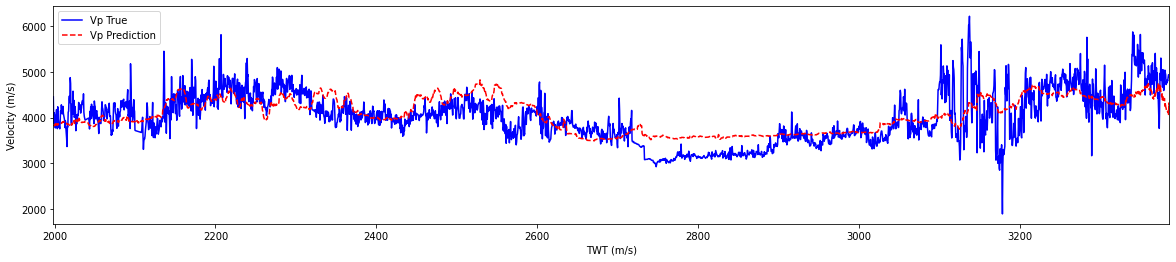

In [314]:
# Plotting and Compare
plt.figure(figsize = (20,4))
plt.plot(well_27['twt'], Y_valid[['vp']].values, color='blue' ,label = "Vp True")
plt.plot(well_27['twt'], predict_vp_inv, "--", color="red", label = "Vp Prediction")

plt.xlim(min(well_27['twt']),max(well_27['twt']))
plt.xlabel('TWT (m/s)')
plt.ylabel("Velocity (m/s)")
plt.legend();

VS (S-Waves Velocity)

In [283]:
model_vs = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, n_jobs=-1, random_state=82).fit(X_train_scaled, Y_train_scaled_vs)

# Predict on validation data
predict_vs = model_vs.predict(X_valid_scaled)

In [284]:
# Inverse scaled transformed predicted values
reshaped_predict_vs = predict_vs.reshape(-1,1)
predict_vs_inv = scaler_vs_v.inverse_transform(reshaped_predict_vs)
predict_vs_inv = np.array(predict_vs_inv)

In [285]:
# Evalutation Metrics
print('MAE Vs:', mean_absolute_error(Y_valid_scaled_vs, predict_vs))
print('R2 Vs:', r2_score(Y_valid_scaled_vs, predict_vs))
print('ME Vs:', max_error(Y_valid_scaled_vs, predict_vs))

MAE Vs: 0.5842836595801171
R2 Vs: 0.4472571414862382
ME Vs: 5.027298442587362


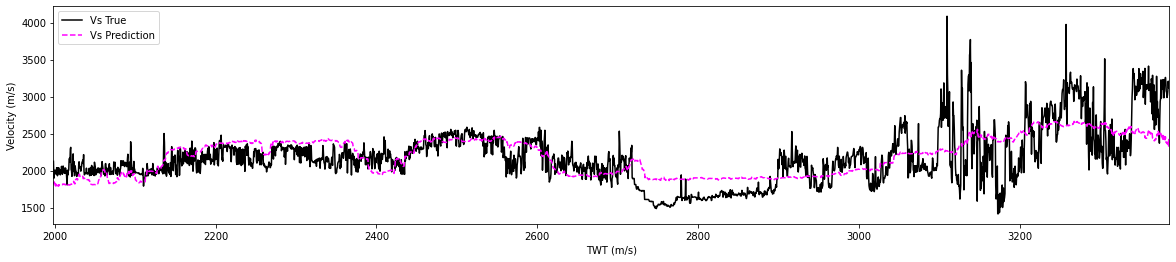

In [313]:
# Plotting and Compare
plt.figure(figsize = (20,4))
plt.plot(well_27['twt'], Y_valid[['vs']].values, color='black' ,label = "Vs True")
plt.plot(well_27['twt'], predict_vs_inv, "--", color="magenta", label = "Vs Prediction")

plt.xlim(min(well_27['twt']),max(well_27['twt']))
plt.xlabel('TWT (m/s)')
plt.ylabel("Velocity (m/s)")
plt.legend();

RHOB (Density of the borehole and the rocks penetrated by the drill bit)

In [288]:
model_rhob = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, n_jobs=-1, random_state=82).fit(X_train_scaled, Y_train_scaled_r)

# Predict on validation data
predict_rhob = model_rhob.predict(X_valid_scaled)

In [289]:
# Inverse scaled transformed predicted values
reshaped_predict_rhob = predict_rhob.reshape(-1,1)
predict_rhob_inv = scaler_r_v.inverse_transform(reshaped_predict_rhob)
predict_rhob_inv = np.array(predict_rhob_inv)

In [290]:
# Evalutation Metrics
print('MAE Vs:', mean_absolute_error(Y_valid_scaled_r, predict_rhob))
print('R2 Vs:', r2_score(Y_valid_scaled_r, predict_rhob))
print('ME Vs:', max_error(Y_valid_scaled_r, predict_rhob))

MAE Vs: 1.6321400559243515
R2 Vs: -0.07919653530386195
ME Vs: 31.563306196205655


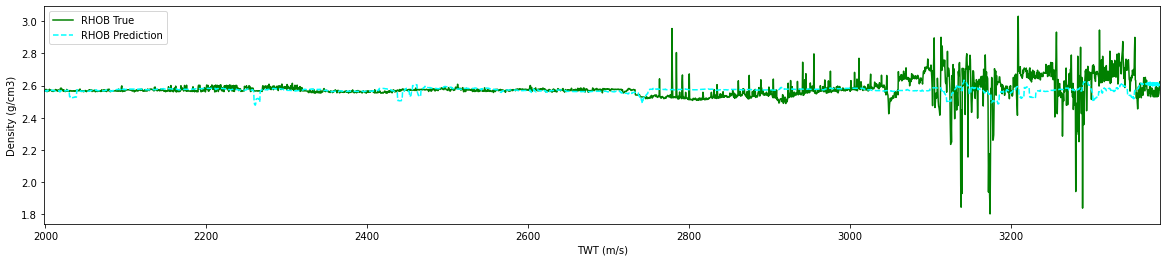

In [312]:
# Plotting and Compare
plt.figure(figsize = (20,4))
plt.plot(well_27['twt'], Y_valid[['rhob']].values, color='green' ,label = "RHOB True", )
plt.plot(well_27['twt'], predict_rhob_inv, "--", color="cyan", label = "RHOB Prediction")

plt.xlim(min(well_27['twt']), max(well_27['twt']))
plt.xlabel('TWT (m/s)')
plt.ylabel("Density (g/cm3)")
plt.legend();

Impedance (Acoustic impedance is a layer property of a rock and it is equal to the product of compressional velocity and density)

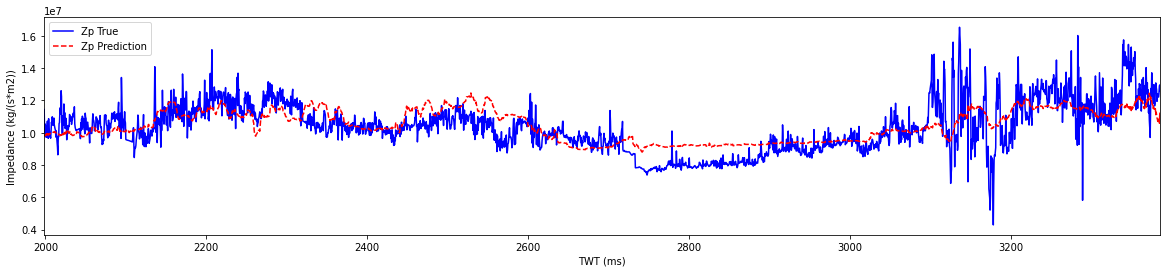

In [318]:
# Zp (P-impedance * RHOB) Validation Data VS. Predicted
Zp_valid = Y_valid['vp'] * Y_valid['rhob'] * 1000
Zp_predict = predict_vp_inv * predict_rhob_inv * 1000

plt.figure(figsize = (20,4))
plt.plot(well_27['twt'],Zp_valid, color='blue', label = 'Zp True')
plt.plot(well_27['twt'],Zp_predict, '--', color = 'red', label = 'Zp Prediction')

plt.xlim(min(well_27['twt']), max(well_27['twt']))
plt.xlabel('TWT (ms)')
plt.ylabel('Impedance (kg/(s*m2))')
plt.legend();

In [320]:
# Zp R2 error
print('Zp R2:', r2_score(Zp_valid, Zp_predict))

Zp R2: 0.46992655764671265


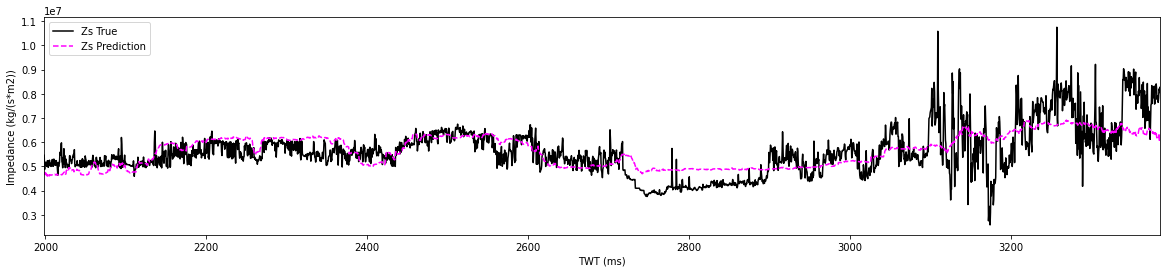

In [319]:
# Zs (S-impedance * RHOB) Validation Data VS. Predicted
Zs_valid = Y_valid['vs'] * Y_valid['rhob'] * 1000
Zs_predict = predict_vs_inv * predict_rhob_inv * 1000

plt.figure(figsize = (20,4))
plt.plot(well_27['twt'],Zs_valid, color='black', label = 'Zs True')
plt.plot(well_27['twt'],Zs_predict, '--', color = 'magenta', label = 'Zs Prediction')

plt.xlim(min(well_27['twt']), max(well_27['twt']))
plt.xlabel('TWT (ms)')
plt.ylabel('Impedance (kg/(s*m2))')
plt.legend();

In [321]:
# Zs R2 error
print('Zs R2:', r2_score(Zs_valid, Zs_predict))

Zs R2: 0.4681648608081055


### 5. Tune the Model with RandomGridSearch and GridSearchCV

##### VP

In [352]:
# First try RandomizedSearchCV to narrow the possibilities
param_grid = {'n_estimators': np.arange(20,160,10), 'learning_rate':[0.1, 0.3, 0.5, 0.7], 'max_depth':[3,5,7,9], 'subsample':np.linspace(0,1,5), 'colsample_bytree':np.linspace(0,1,5)}
xgb_vp_model = RandomizedSearchCV(XGBRegressor(n_jobs=-1, random_state=82), param_distributions=param_grid, n_iter=2, cv=5, verbose=True)
xgb_vp_model.fit(X_train_scaled, Y_train_scaled_vp)
xgb_vp_model.best_params_

Fitting 5 folds for each of 2 candidates, totalling 10 fits


{'subsample': 0.5,
 'n_estimators': 140,
 'max_depth': 7,
 'learning_rate': 0.5,
 'colsample_bytree': 0.25}

In [353]:
# The GridSearchCV to probe all parameters
param_grid_g = {'n_estimators': [120, 130, 140], 'learning_rate':[0.7, 0.9], 'max_depth':[9,10], 'colsample_bytree':[0.4,0.5,0.6]}
xgb_vp_model_g = GridSearchCV(XGBRegressor(n_jobs=-1, random_state=82), param_grid_g, cv=2, verbose=True)
xgb_vp_model_g.fit(X_train_scaled, Y_train_scaled_vp)

Fitting 2 folds for each of 36 candidates, totalling 72 fits


GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...tep=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=-1, num_parallel_tree=None,
                                    predictor=None, random_state=82,
                                    reg_alpha=None, reg_lambda=None, ...),
             param_grid={'colsample_bytree': [0.4, 0.5, 0.6],
                         'learning_rate': [0.7, 0.9], 'max_depth': [9, 10],
                         'n_estimators': [120, 130, 140]},
             verbose=True)

In [354]:
xgb_vp_model_g.best_params_

{'colsample_bytree': 0.4,
 'learning_rate': 0.7,
 'max_depth': 10,
 'n_estimators': 120}

In [355]:
# Tuned model with best parameters
model_vp_1 = XGBRegressor(n_estimators=120, learning_rate=0.7, max_depth=10, colsample_bytree=0.4, n_jobs=-1, random_state=82).fit(X_train_scaled, Y_train_scaled_vp)
predict_vp_1 = model_vp_1.predict(X_valid_scaled)

# Evalutation Metrics
print('MAE Vp:', mean_absolute_error(Y_valid_scaled_vp, predict_vp_1))
print('R2 Vp:', r2_score(Y_valid_scaled_vp, predict_vp_1))
print('ME Vp:', max_error(Y_valid_scaled_vp, predict_vp_1))

MAE Vp: 0.5613583147267428
R2 Vp: 0.10987152814929801
ME Vp: 3.450209529647342


##### VS

In [356]:
# First try RandomizedSearchCV to narrow the possibilities
param_grid = {'n_estimators': np.arange(20,160,10), 'learning_rate':[0.1, 0.3, 0.5, 0.7], 'max_depth':[3,5,7,9], 'subsample':np.linspace(0,1,5), 'colsample_bytree':np.linspace(0,1,5)}
xgb_vs_model = RandomizedSearchCV(XGBRegressor(n_jobs=-1, random_state=82), param_distributions=param_grid, n_iter=2, cv=5, verbose=True)
xgb_vs_model.fit(X_train_scaled, Y_train_scaled_vs)
xgb_vs_model.best_params_

Fitting 5 folds for each of 2 candidates, totalling 10 fits


{'subsample': 0.75,
 'n_estimators': 100,
 'max_depth': 3,
 'learning_rate': 0.7,
 'colsample_bytree': 0.75}

In [357]:
# The GridSearchCV to probe all parameters
param_grid_g = {'n_estimators': np.arange(90, 120, 10), 'learning_rate':[0.7, 0.9], 'max_depth':[3,4], 'colsample_bytree':[0.6,0.8], 'subsample':[0.7,0.8]}
xgb_vs_model_g = GridSearchCV(XGBRegressor(n_jobs=-1, random_state=82), param_grid_g, cv=2, verbose=True)
xgb_vs_model_g.fit(X_train_scaled, Y_train_scaled_vs)

Fitting 2 folds for each of 48 candidates, totalling 96 fits


GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=-1, num_parallel_tree=None,
                                    predictor=None, random_state=82,
                                    reg_alpha=None, reg_lambda=None, ...),
             param_grid={'colsample_bytree': [0.6, 0.8],
                         'learning_rate': [0.7, 0.9], 'max_depth': [3, 4],
                         'n_estimators': array([ 90, 100, 110]),
                         'subsample': [0.7, 0.8]},
             verbose=True)

In [358]:
xgb_vs_model_g.best_params_

{'colsample_bytree': 0.8,
 'learning_rate': 0.7,
 'max_depth': 4,
 'n_estimators': 100,
 'subsample': 0.8}

In [359]:
model_vs_1 = XGBRegressor(n_estimators=100, learning_rate=0.7, max_depth=4, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, n_jobs=-1, random_state=82).fit(X_train_scaled, Y_train_scaled_vs)
predict_vs_1 = model_vs_1.predict(X_valid_scaled)

# Evalutation Metrics
print('MAE Vp:', mean_absolute_error(Y_valid_scaled_vs, predict_vs_1))
print('R2 Vp:', r2_score(Y_valid_scaled_vs, predict_vs_1))
print('ME Vp:', max_error(Y_valid_scaled_vs, predict_vs_1))

MAE Vp: 0.6229507738660591
R2 Vp: 0.28106903347555257
ME Vp: 5.6152869384140836


##### RHOB

In [360]:
# First try RandomizedSearchCV to narrow the possibilities
param_grid = {'n_estimators': np.arange(20,160,10), 'learning_rate':[0.1, 0.3, 0.5, 0.7], 'max_depth':[3,5,7,9], 'subsample':np.linspace(0,1,5), 'colsample_bytree':np.linspace(0,1,5)}
xgb_r_model = RandomizedSearchCV(XGBRegressor(n_jobs=-1, random_state=82), param_distributions=param_grid, n_iter=2, cv=5, verbose=True)
xgb_r_model.fit(X_train_scaled, Y_train_scaled_r)
xgb_r_model.best_params_

Fitting 5 folds for each of 2 candidates, totalling 10 fits


{'subsample': 0.5,
 'n_estimators': 80,
 'max_depth': 9,
 'learning_rate': 0.3,
 'colsample_bytree': 1.0}

In [361]:
# The GridSearchCV to probe all parameters
param_grid_g = {'n_estimators': np.arange(80, 100, 10), 'learning_rate':[0.3, 0.5, 0.7], 'max_depth':[8,10], 'subsample':[0.5,0.7,0.9]}
xgb_r_model_g = GridSearchCV(XGBRegressor(n_jobs=-1, random_state=82), param_grid_g, cv=2, verbose=True)
xgb_r_model_g.fit(X_train_scaled, Y_train_scaled_r)

Fitting 2 folds for each of 36 candidates, totalling 72 fits


GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat..._step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=-1, num_parallel_tree=None,
                                    predictor=None, random_state=82,
                                    reg_alpha=None, reg_lambda=None, ...),
             param_grid={'learning_rate': [0.3, 0.5, 0.7], 'max_depth': [8, 10],
                         'n_estimators': array([80, 90]),
                         'subsample': [0.5, 0.7, 0.9]},
             verbose=True)

In [363]:
xgb_r_model_g.best_params_

{'learning_rate': 0.3, 'max_depth': 8, 'n_estimators': 80, 'subsample': 0.7}

In [364]:
model_r_1 = XGBRegressor(n_estimators=80, learning_rate=0.3, max_depth=8, min_child_weight=1, gamma=0, subsample=0.7, n_jobs=-1, random_state=82).fit(X_train_scaled, Y_train_scaled_r)
predict_r_1 = model_r_1.predict(X_valid_scaled)

# Evalutation Metrics
print('MAE Vp:', mean_absolute_error(Y_valid_scaled_r, predict_r_1))
print('R2 Vp:', r2_score(Y_valid_scaled_r, predict_r_1))
print('ME Vp:', max_error(Y_valid_scaled_r, predict_r_1))

MAE Vp: 1.4497172996017031
R2 Vp: 0.051147203076990055
ME Vp: 32.81973133849387


### 6. Summary

VP

In [370]:
summary = pd.DataFrame(columns=['Baseline_VP', 'Model 1_VP', 'Baseline_VS', 'Model 1_VS', 'Baseline_RHOB', 'Model 1_RHOB'], index=['MAE', 'R2', 'ME'])

# VP
summary['Baseline_VP']['MAE'] = mean_absolute_error(Y_valid_scaled_vp, predict_vp)
summary['Baseline_VP']['R2'] = r2_score(Y_valid_scaled_vp, predict_vp)
summary['Baseline_VP']['ME'] = max_error(Y_valid_scaled_vp, predict_vp)
summary['Model 1_VP']['MAE'] = mean_absolute_error(Y_valid_scaled_vp, predict_vp_1)
summary['Model 1_VP']['R2'] = r2_score(Y_valid_scaled_vp, predict_vp_1)
summary['Model 1_VP']['ME'] = max_error(Y_valid_scaled_vp, predict_vp_1)

# VS
summary['Baseline_VS']['MAE'] = mean_absolute_error(Y_valid_scaled_vs, predict_vs)
summary['Baseline_VS']['R2'] = r2_score(Y_valid_scaled_vs, predict_vs)
summary['Baseline_VS']['ME'] = max_error(Y_valid_scaled_vs, predict_vs)
summary['Model 1_VS']['MAE'] = mean_absolute_error(Y_valid_scaled_vs, predict_vs_1)
summary['Model 1_VS']['R2'] = r2_score(Y_valid_scaled_vs, predict_vs_1)
summary['Model 1_VS']['ME'] = max_error(Y_valid_scaled_vs, predict_vs_1)

# RHOB
summary['Baseline_RHOB']['MAE'] = mean_absolute_error(Y_valid_scaled_r, predict_rhob)
summary['Baseline_RHOB']['R2'] = r2_score(Y_valid_scaled_r, predict_rhob)
summary['Baseline_RHOB']['ME'] = max_error(Y_valid_scaled_r, predict_rhob)
summary['Model 1_RHOB']['MAE'] = mean_absolute_error(Y_valid_scaled_r, predict_r_1)
summary['Model 1_RHOB']['R2'] = r2_score(Y_valid_scaled_r, predict_r_1)
summary['Model 1_RHOB']['ME'] = max_error(Y_valid_scaled_r, predict_r_1)

summary

,Baseline_VP,Model 1_VP,Baseline_VS,Model 1_VS,Baseline_RHOB,Model 1_RHOB
MAE,0.414987,0.561358,0.584284,0.622951,1.63214,1.449717
R2,0.486648,0.109872,0.447257,0.281069,-0.079197,0.051147
ME,3.056705,3.45021,5.027298,5.615287,31.563306,32.819731


### References
- https://www.crewes.org/ResearchLinks/DataScience/datascience.php?year=2021

### Conclusions

Model(VP, VS and RHOB) have not improved so baseline models are better and faster.